In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter('ignore')

#### pystan windows C++ compiler

* conda install libpython m2w64-toolchain -c msys2 --yes 

In [2]:
import os
import platform

dependencies_installed = True
if platform.system() == 'Windows' and not dependencies_installed:
    os.system("conda install libpython m2w64-toolchain -c msys2 --yes")

In [3]:
### pystan leveraged by fbprophet need to test before using kats
import pystan

if not dependencies_installed:
    model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
    model = pystan.StanModel(model_code=model_code)  # this will take a minute
    y = model.sampling(n_jobs=1).extract()['y']
    print(y.mean())  # should be close to 0

In [4]:
import pandas as pd
import numpy as np
from kats.consts import TimeSeriesData

def retrieve_example_url(csv_name):
    url_path = f'https://raw.githubusercontent.com/facebookresearch/Kats/master/kats/data/{csv_name}.csv'
    return url_path

#### Ensemble Air Passengers Univariate Example

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Generated forecast data from arima model.
INFO:root:Generated forecast data from SARIMA model.
INFO:root:Generated forecast data from Prophet model.
INFO:root:Generated forecast data from theta model.
INFO:root:Generated forecast data from Prophet model.
INFO:root:Generated forecast data from theta model.
INFO:root:Generating chart for forecast result from Ensemble model.
INFO:root:Generating chart for forecast result.


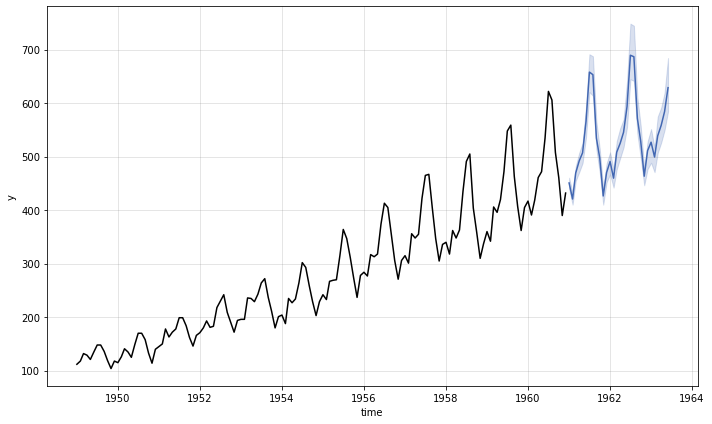

In [5]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (arima, holtwinters, linear_model, prophet, quadratic_model, sarima, theta)

air_passengers_df = pd.read_csv(retrieve_example_url(csv_name='air_passengers'))
air_passengers_df.columns = ['time','value']
air_passengers_ts = TimeSeriesData(air_passengers_df)
model_params = EnsembleParams(
    [
        BaseModelParams('arima',arima.ARIMAParams(p=1,d=1,q=1)),
        BaseModelParams('sarima',sarima.SARIMAParams(p=2,d=1,q=1,trend='ct',seasonal_order=(1,0,1,12),enforce_invertibility=False,enforce_stationarity=False)),
        BaseModelParams('prophet',prophet.ProphetParams(seasonality_mode='multiplicative')),
        BaseModelParams('linear',linear_model.LinearModelParams()),
        BaseModelParams('quadratic',quadratic_model.QuadraticModelParams()),
        BaseModelParams('theta',theta.ThetaParams(m=12)),
    ]
)
KatsEnsembleParam = {
    'models':model_params,
    'aggregation':'median',
    'seasonality_length':12,
    'decomposition_method':'multiplicative',
}
m = KatsEnsemble(data=air_passengers_ts,params=KatsEnsembleParam)
m.fit()
fcst = m.predict(steps=30)
m.aggregate()
m.plot()

#### Multivariate Example

INFO:root:Created VAR model.
INFO:root:Fitted VAR model.
INFO:root:Generated forecast data from VAR model.
INFO:root:Generating chart for forecast result from VAR model.


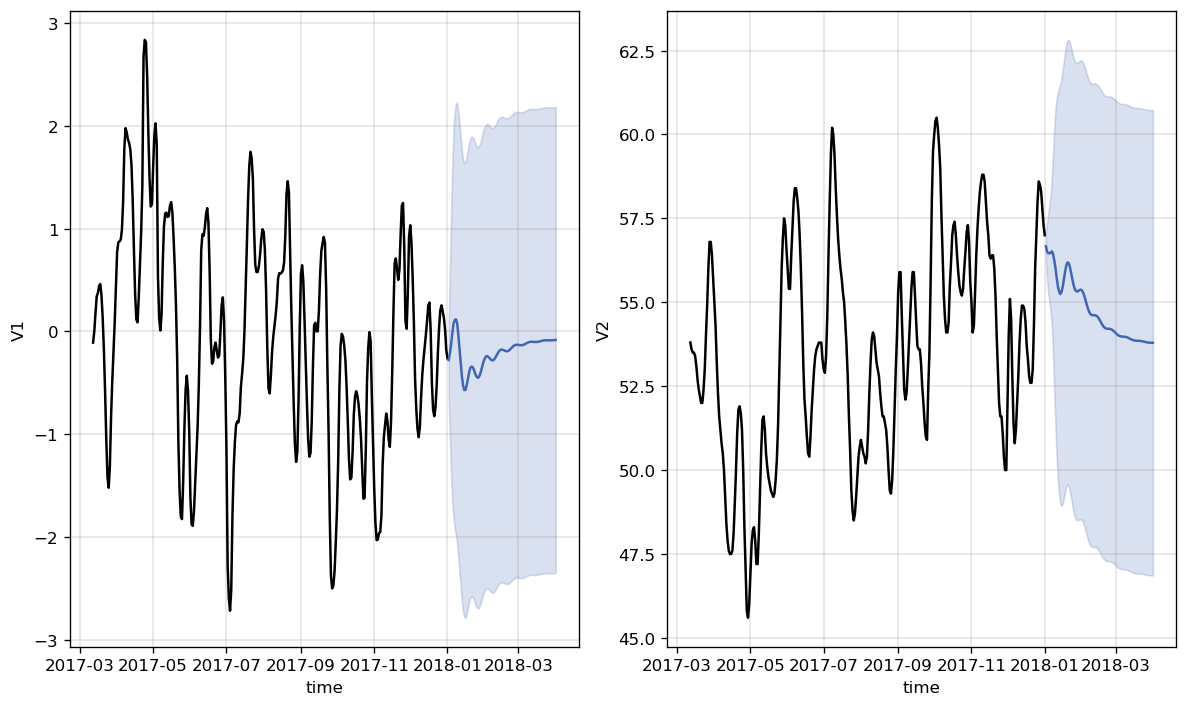

In [6]:
from kats.models.var import VARModel, VARParams

multi_df = pd.read_csv(retrieve_example_url(csv_name='multi_ts'),index_col=0)
multi_ts = TimeSeriesData(multi_df)
multi_params = VARParams()
multi_m = VARModel(multi_ts, multi_params)
multi_m.fit()
multi_fcst = multi_m.predict(steps=90)
multi_m.plot()

#### CUSUM Changepoint Detection

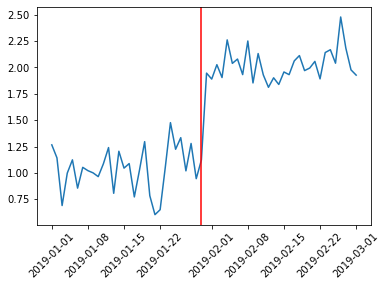

In [7]:
from kats.detectors.cusum_detection import CUSUMDetector
import matplotlib.pyplot as plt

np.random.seed(10)
data_dict = {
    'time': pd.date_range('2019-01-01', periods=60),
    'increase':np.concatenate([np.random.normal(1,0.2,30), np.random.normal(2,0.2,30)]),
    'decrease':np.concatenate([np.random.normal(1,0.3,50), np.random.normal(0.5,0.3,10)]),
}
df_increase_decrease = pd.DataFrame.from_dict(data_dict)
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(change_directions=['increase'])
plt.xticks(rotation=45)
detector.plot(change_points)

#### Interest Windows

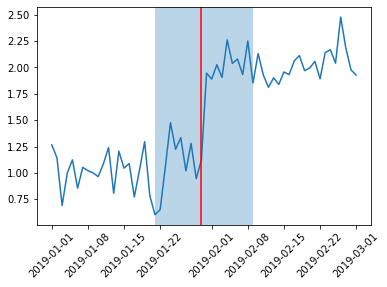

In [8]:
interest_window_change_points = detector.detector(change_directions=['increase'],interest_window=[20,40])
plt.clf()
plt.xticks(rotation=45)
detector.plot(interest_window_change_points)

#### Another CUSUM Example

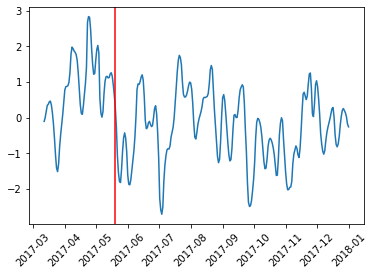

In [9]:
plt.clf()
multi_df_cusum = multi_df.copy()
multi_df_cusum = multi_df_cusum[['time','V1']]
multi_ts_cusum = TimeSeriesData(multi_df_cusum)
test_detector = CUSUMDetector(multi_ts_cusum)
test_change_points = test_detector.detector(change_directions=['decrease'])
plt.xticks(rotation=45)
test_detector.plot(test_change_points)

#### Bayesian Online Change Point Detection (BOPCD)

INFO:root:Plotting time series


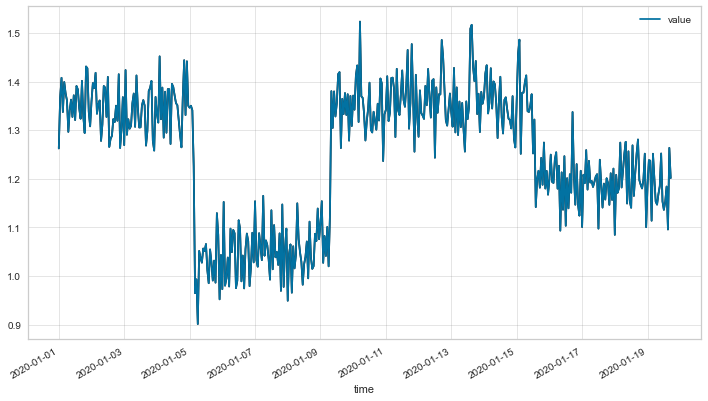

In [73]:
from kats.utils.simulator import Simulator

sim = Simulator(n=450,start='2020-01-01',freq='H')
ts_bocpd = sim.level_shift_sim(noise=0.05,seasonal_period=1)
ts_bocpd.plot(cols=['value'])

INFO:kats.utils.time_series_parameter_tuning:Parameter tuning search space dimensions: [{'name': 'known_prec_multiplier', 'type': 'choice', 'values': [1.0, 2.0, 3.0, 4.0, 5.0], 'value_type': 'float', 'is_ordered': False}, {'name': 'cp_prior', 'type': 'choice', 'values': [0.001, 0.002, 0.005, 0.01, 0.02], 'value_type': 'float', 'is_ordered': False}]
INFO:kats.utils.time_series_parameter_tuning:Search space is created.
INFO:kats.utils.time_series_parameter_tuning:Experiment is created.
INFO:kats.utils.time_series_parameter_tuning:Seed that is used in random search: 100
INFO:kats.utils.time_series_parameter_tuning:A SearchMethodEnum.RANDOM_SEARCH_UNIFORM model for candidate parameter value generation is created.
INFO:kats.utils.time_series_parameter_tuning:A RandomSearch object is successfully created.
INFO:root:Plotting 4 change points for value.


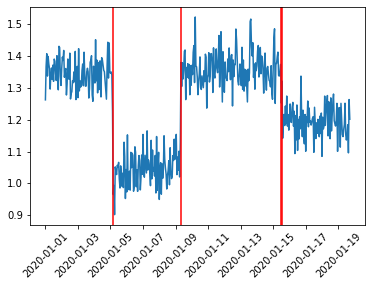

In [11]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

test_BOCPD_detector = BOCPDetector(ts_bocpd)
test_BOCPD_changepoints = test_BOCPD_detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL # default
    )
plt.clf()
plt.xticks(rotation=45)
test_BOCPD_detector.plot(test_BOCPD_changepoints)

In [12]:
cp, meta = test_BOCPD_changepoints[0]
print(cp)
print('\nBOCPDMetadata:')
for members in dir(meta):
    if not members.startswith('_'):
        print(f'{members}: {getattr(meta,members)}')

TimeSeriesChangePoint(start_time: 2020-01-05T03:00:00.000000000, end_time: 2020-01-05T03:00:00.000000000, confidence: 0.9752663452994146)

BOCPDMetadata:
detector_type: <class 'kats.detectors.bocpd.BOCPDetector'>
model: BOCPDModelType.NORMAL_KNOWN_MODEL
ts_name: value


#### RobustStatDetector

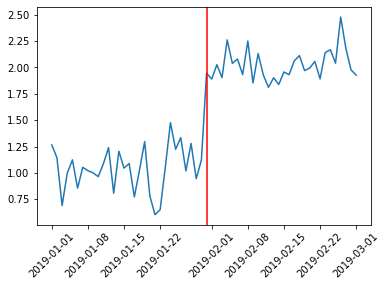

In [13]:
from kats.detectors.robust_stat_detection import RobustStatDetector

rs_detector_1 = RobustStatDetector(tsd)
rs_change_points_1 = rs_detector_1.detector()
plt.clf()
plt.xticks(rotation=45)
rs_detector_1.plot(rs_change_points_1)

#### RobustStatDetector Can Detect Multiple Changepoints

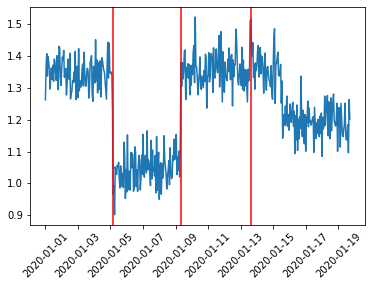

In [14]:
plt.clf()
ts_bocpd = TimeSeriesData(ts_bocpd.to_dataframe())
rs_detector_2 = RobustStatDetector(ts_bocpd)
rs_change_points_2 = rs_detector_2.detector(p_value_cutoff=5e-3, comparison_window=2)
plt.xticks(rotation=45)
rs_detector_2.plot(rs_change_points_2)

#### Outlier Detection

In [15]:
from kats.detectors.outlier import OutlierDetector
air_passengers_df_outliers = pd.read_csv(retrieve_example_url(csv_name='air_passengers'))
air_passengers_df_outliers.columns = ['time','value']
air_passengers_df_outliers.loc[air_passengers_df_outliers.time == '1950-12-01','value']*=5
air_passengers_df_outliers.loc[air_passengers_df_outliers.time == '1959-12-01','value']*=4
air_passengers_ts_outliers = TimeSeriesData(air_passengers_df_outliers)
ts_outlierDetector = OutlierDetector(air_passengers_ts_outliers,'additive')
ts_outlierDetector.detector()
ts_outlierDetector.outliers[0]

[Timestamp('1950-12-01 00:00:00'),
 Timestamp('1959-11-01 00:00:00'),
 Timestamp('1959-12-01 00:00:00')]

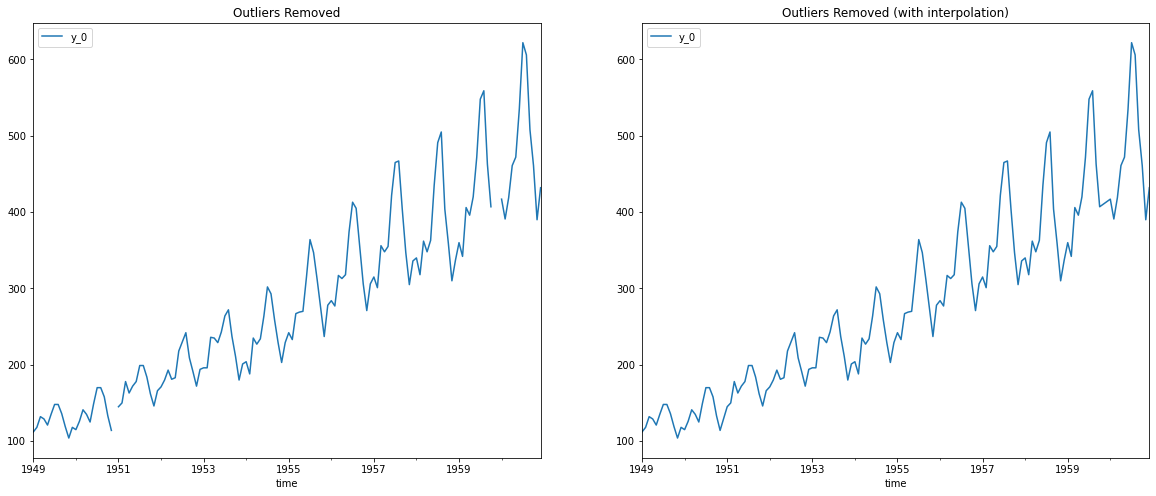

In [16]:
air_passengers_ts_remove_outlier = ts_outlierDetector.remover(interpolate=False)
air_passengers_ts_remove_outlier_interpolate = ts_outlierDetector.remover(interpolate=True)
fig, ax = plt.subplots(figsize=(20,8),nrows=1,ncols=2)
x_label,y_label = 'time','y_0'
rmv_title, inter_title = 'Outliers Removed','Outliers Removed (with interpolation)'
air_passengers_ts_remove_outlier.to_dataframe().plot(x=x_label,y=y_label,ax=ax[0])
air_passengers_ts_remove_outlier_interpolate.to_dataframe().plot(x=x_label,y=y_label,ax=ax[1])
ax[0].set_title(rmv_title)
ax[1].set_title(inter_title)
plt.show()

#### MultivariateAnomalyDetector

INFO:root:Plotting time series


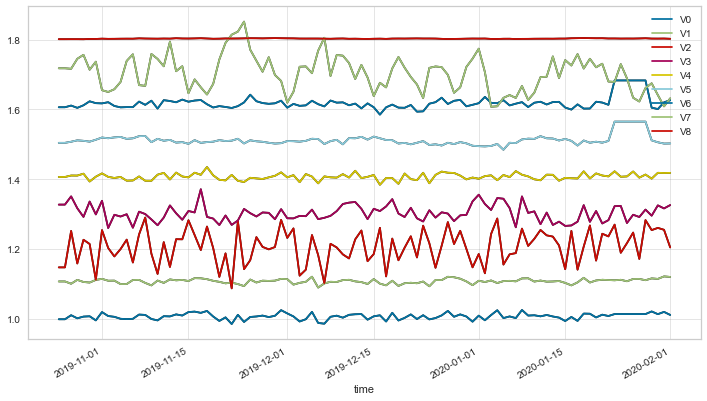

In [126]:
from kats.detectors.outlier import MultivariateAnomalyDetector, MultivariateAnomalyDetectorType
from kats.models.var import VARParams

warnings.filterwarnings(action='ignore',category=FutureWarning)
multi_anomaly_df = pd.read_csv(retrieve_example_url(csv_name='multivariate_anomaly_simulated_data'))
multi_anomaly_df.columns = ['V0','V1','V2','V3','V4','V5','V6','V7','V8','time']
multi_anomaly_cols = multi_anomaly_df.columns.tolist()
reorder_cols = multi_anomaly_cols[-1:] + multi_anomaly_cols[:-1]
multi_anomaly_df = multi_anomaly_df[reorder_cols]
multi_anomaly_ts = TimeSeriesData(multi_anomaly_df)
multi_anomaly_ts.plot(cols=multi_anomaly_ts.value.columns.tolist())

MultivariateAnomalyDetector has an open issue on GitHub will pivot to PyCaret

In [132]:
# np.random.seed(10)
# params = VARParams(maxlags=2)
# d = MultivariateAnomalyDetector(multi_anomaly_ts, params, training_days=60, model_type=MultivariateAnomalyDetectorType.VAR)
# anomaly_score_df = d.detector()
# d.plot()

#### PyCaret Anomaly Detection

In [39]:
from pycaret.utils import version
print(f'pycaret version: {version()}')

pycaret version: 2.3.1


In [40]:
import configparser
import os

config = configparser.ConfigParser()
config.read('config.ini')
mlflow_uri = config['mlflow']['mlflow_uri']
mlflow_artifact_uri = config['mlflow']['target_mlflow_artifact_uri']

In [41]:
import mlflow

mlflow.set_tracking_uri(mlflow_uri)

In [62]:
from pycaret.anomaly import *

username = os.getenv('USER_UID')
n_days = 60
last_n_days_multi_anomaly_df = multi_anomaly_df.iloc[-n_days:,:][['V0','V1','V2','V3','V4','V5','V6','V7','V8']]
mutli_anomaly1 = setup(data=last_n_days_multi_anomaly_df, log_experiment=False, experiment_name=f'multi_anomaly1_{username}')

,Description,Value
0,session_id,7840
1,Original Data,"(60, 9)"
2,Missing Values,False
3,Numeric Features,9
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(60, 9)"
9,CPU Jobs,-1


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='UNSUPERVISED_DUMMY_TARGET',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical=None,
                                fill_value_numerical=None...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
        

In [63]:
models()

INFO:logs:gpu_param set to False


,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [68]:
one_class_svm_model = create_model('svm')

INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:OCSVM(cache_size=200, coef0=0.0, contamination=0.05, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)
INFO:logs:create_model() succesfully completed......................................


In [69]:
one_class_svm_results = assign_model(one_class_svm_model)
one_class_svm_results.head()

INFO:logs:Initializing assign_model()
INFO:logs:assign_model(model=OCSVM(cache_size=200, coef0=0.0, contamination=0.05, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False), transformation=False, score=True, verbose=True)
INFO:logs:Checking exceptions
INFO:logs:Determining Trained Model
INFO:logs:Trained Model : One-class SVM detector
INFO:logs:Copying data
INFO:logs:(60, 11)
INFO:logs:assign_model() succesfully completed......................................


,V0,V1,V2,V3,V4,V5,V6,V7,V8,Anomaly,Anomaly_Score
40,0.999690,1.106863,1.141474,1.294538,1.415185,1.510259,1.611758,1.723255,1.802886,0,0.002317
41,1.020785,1.121432,1.240628,1.313416,1.408005,1.516200,1.625015,1.703747,1.802921,0,-0.011773
42,0.989005,1.090235,1.183230,1.286135,1.388534,1.515453,1.615102,1.768293,1.802900,0,0.008443
43,0.986922,1.102095,1.102897,1.289978,1.408487,1.501071,1.608772,1.805250,1.802596,1,0.064911
44,1.006710,1.106855,1.215640,1.295623,1.405748,1.509453,1.625588,1.695868,1.802330,0,-0.016189


In [70]:
plot_model(one_class_svm_model,plot='umap') 
# two plot options are: 'umap', 'tsne'

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [71]:
anomaly_preds = predict_model(one_class_svm_model, data=last_n_days_multi_anomaly_df)
anomaly_preds[anomaly_preds['Anomaly'] > 0]

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=OCSVM(cache_size=200, coef0=0.0, contamination=0.05, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False), ml_usecase=MLUsecase.ANOMALY)


,V0,V1,V2,V3,V4,V5,V6,V7,V8,Anomaly,Anomaly_Score
43,0.986922,1.102095,1.102897,1.289978,1.408487,1.501071,1.608772,1.805250,1.802596,1,0.064911
71,1.025427,1.103270,1.288011,1.346539,1.397564,1.501441,1.617836,1.609079,1.801821,1,0.036413
95,1.014452,1.111357,1.283415,1.313440,1.413697,1.565253,1.683127,1.661408,1.803803,1,0.024389


In [72]:
multi_anomaly_df.iloc[[43,71,95],:]

,time,V0,V1,V2,V3,V4,V5,V6,V7,V8
43,2019-12-07,0.986922,1.102095,1.102897,1.289978,1.408487,1.501071,1.608772,1.805250,1.802596
71,2020-01-04,1.025427,1.103270,1.288011,1.346539,1.397564,1.501441,1.617836,1.609079,1.801821
95,2020-01-28,1.014452,1.111357,1.283415,1.313440,1.413697,1.565253,1.683127,1.661408,1.803803


#### statsmodels VAR multivariate anomaly detection

In [159]:
from statsmodels.tsa.vector_ar.var_model import VAR

multi_anomaly_df_copy = multi_anomaly_df.copy()
n_days = 120
multi_anomaly_df_copy = multi_anomaly_df_copy.iloc[-n_days:,:]
multi_anomaly_df_copy['time'] = pd.to_datetime(multi_anomaly_df_copy['time']).apply(lambda t: t.date())
multi_anomaly_df_copy = multi_anomaly_df_copy.set_index('time')
AIC = {}
best_aic, best_order = np.inf, 0
for num_lags in range(1,3):
    stats_model = VAR(endog=multi_anomaly_df_copy)
    var_result = stats_model.fit(maxlags=num_lags)
    AIC[num_lags] = var_result.aic
    if AIC[num_lags] < best_aic:
        best_aic = AIC[num_lags]
        best_order = num_lags
print(f'BEST ORDER: {best_order}\nBEST AIC: {best_aic}')

BEST ORDER: 2
BEST AIC: -86.47485774626034


In [160]:
anomaly_var = VAR(endog=multi_anomaly_df_copy)
anomaly_var_result = anomaly_var.fit(maxlags=best_order)
# compute train Hotelling T-squared metric
resids_mean = anomaly_var_result.resid.values.mean(axis=0)
resids_std = anomaly_var_result.resid.values.std(axis=0)
resids = (anomaly_var_result.resid.values-resids_mean)/resids_std
cov_resids = np.linalg.inv(np.cov(resids.T))
T_squared = np.diag((resids).dot(cov_resids).dot(resids.T))

In [161]:
import scipy

# compute Upper Control Limit
m,p = anomaly_var_result.nobs, anomaly_var_result.resid.shape[-1]
alpha= 0.01
UCL = scipy.stats.f.ppf(1-alpha,dfn=p,dfd=m-p)*(p*(m+1)*(m-1)/(m*m-m*p))

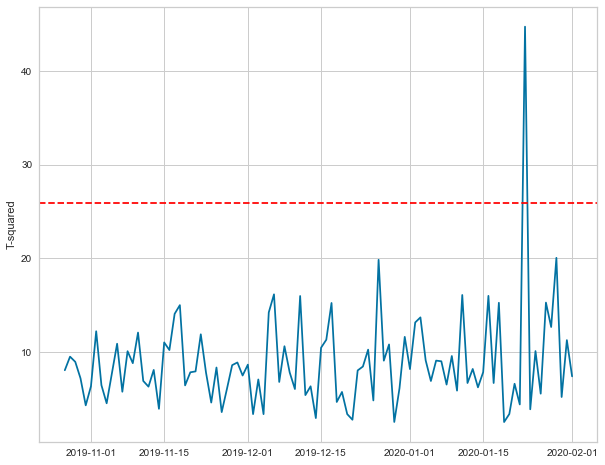

In [162]:
import matplotlib.pyplot as plt

# plot T-squared metric
plt.figure(figsize=(10,8))
plt.plot(multi_anomaly_df_copy.index[best_order:], T_squared)
plt.ylabel('T-squared')
plt.axhline(UCL,c='red',linestyle='--')

#### Trend Detection

INFO:root:Plotting time series


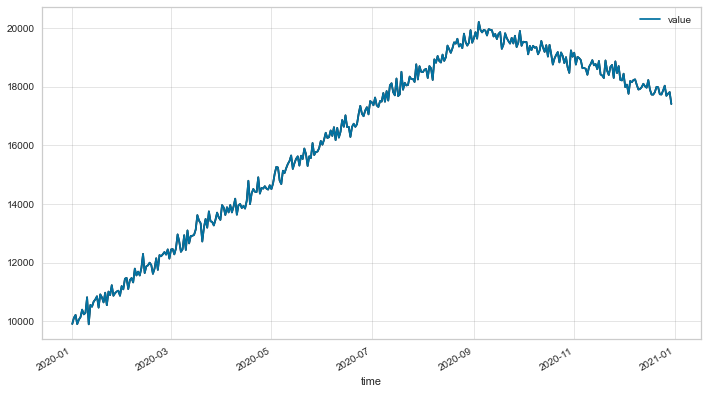

In [85]:
trend_sim = Simulator(n=365,start='2020-01-01',freq='D')
tsd = trend_sim.trend_shift_sim(noise=200,seasonal_period=7,seasonal_magnitude=7e-3,cp_arr=[250],intercept=1e4,trend_arr=[40,-20])
tsd.plot(cols=['value'])

INFO:root:Performing trend detection on the whole time series...


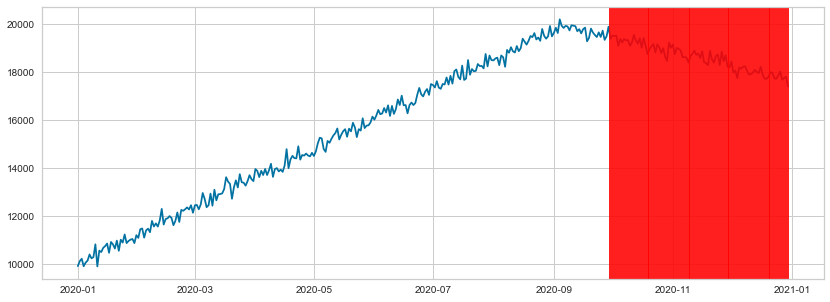

In [86]:
from kats.detectors.trend_mk import MKDetector

trend_detector = MKDetector(data=tsd,threshold=0.8)
detected_time_points = trend_detector.detector(direction='down',window_size=20,freq='weekly')
trend_detector.plot(detected_time_points)

In [87]:
trend_cp, trend_meta = detected_time_points[0]
trend_cp

TimeSeriesChangePoint(start_time: 2020-09-30 00:00:00, end_time: 2020-09-30 00:00:00, confidence: 0.9999993093533566)

In [88]:
trend_meta.__dict__

{'_detector_type': kats.detectors.trend_mk.MKDetector,
 '_is_multivariate': False,
 '_trend_direction': 'decreasing',
 '_Tau': -0.8105263157894737}